# Simulate proteome time profiles.
## Start from measured proteome that is already hedged: necessary to enable lactate usage later?

# Using D Heckmann's kapps

## Select kapps associated with pathways relevant to the 6 C srcs since many others too low

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.float_format', lambda x: '%.3g' % x)
%matplotlib inline

In [2]:
PROTOTYPE = False

In [3]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

In [4]:
df_dh = pd.read_csv('/home/laurence/ME/data/DHeckmann/kappmax_rf_dl_iJO.csv')

In [5]:
import re
from cobra.io import load_json_model

ijo = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

rows = []
biggids = df_dh['bigg.id'].apply(lambda x: re.sub(r'(_[b|f]$)', '',x)).unique()
missed = []
for biggid in biggids:
    try:
        sdata = me.stoichiometric_data.get_by_id(biggid)
        mrxn = ijo.reactions.get_by_id(biggid)
        rname = mrxn.name
        for rxn in sdata.parent_reactions:
            rows.append({'bigg_id':biggid, 'rxn':rxn.id, 'name':rname, 'keff_nominal':rxn.keff, 'subsystem':mrxn.subsystem})
    except KeyError:
        missed.append(biggid)
        
df_rmap = pd.DataFrame(rows)
        
print 'biggids not mapped:', len(missed)

biggids not mapped: 252


In [6]:
df_rmap.head(2)

,bigg_id,keff_nominal,name,rxn,subsystem
0,12DGR120tipp,65.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C12:0)",12DGR120tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
1,12DGR140tipp,65.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C14:0)",12DGR140tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"


In [7]:
df_rmap.subsystem.unique()

array([u'Transport, Inner Membrane', u'Transport, Outer Membrane Porin',
       u'Transport, Outer Membrane', u'Nucleotide Salvage Pathway',
       u'Glycerophospholipid Metabolism', u'Alternate Carbon Metabolism',
       u'Cofactor and Prosthetic Group Biosynthesis', u'Murein Recycling',
       u'Nitrogen Metabolism', u'Methylglyoxal Metabolism',
       u'Cell Envelope Biosynthesis', u'Arginine and Proline Metabolism',
       u'Membrane Lipid Metabolism', u'Pyruvate Metabolism',
       u'Tyrosine, Tryptophan, and Phenylalanine Metabolism',
       u'Valine, Leucine, and Isoleucine Metabolism',
       u'Lipopolysaccharide Biosynthesis / Recycling', u'Unassigned',
       u'Citric Acid Cycle', u'Cysteine Metabolism',
       u'Purine and Pyrimidine Biosynthesis',
       u'Inorganic Ion Transport and Metabolism', u'Methionine Metabolism',
       u'Alanine and Aspartate Metabolism',
       u'Threonine and Lysine Metabolism', u'Histidine Metabolism',
       u'Oxidative Phosphorylation', u'Gly

## Only keep kapps for subsystems that are probably accurate

In [8]:
SUBSYS_TUNE = ['Alternate Carbon Metabolism',
               'Glycolysis/Gluconeogenesis']

In [9]:
df_manual = pd.merge(df_dh.rename(columns={'bigg.id':'bigg_id'}), df_rmap[ df_rmap.subsystem.isin(SUBSYS_TUNE)], on='bigg_id')

In [10]:
print df_manual.shape

(185, 18)


In [11]:
df_manual.head(2)

,bigg_id,kappmax.pred.rf.wo.impu,kappmax.pred.rf.w.impu,kappmax.pred.rf.w.impu.const.flux,kappmax.pred.rf.wo.impu.train.impu,kappmax.pred.rf.w.impu.train.impu,kappmax.pred.rf.w.impu.const.flux.train.impu,kappmax.pred.dl.wo.impu,kappmax.pred.dl.w.impu,kappmax.pred.dl.w.impu.const.flux,kappmax.pred.dl.wo.impu.train.impu,kappmax.pred.dl.w.impu.impu.train.impu,kappmax.pred.dl.w.impu.const.flux.impu.train.impu,experim_kappmax,keff_nominal,name,rxn,subsystem
0,2DGULRGx,8.046298,6.173633,0.00007,9.487162,15.761752,0.000303,0.631226,1.988147,5.039821e-08,4.610567,12.793132,3.176270e-07,NaN,51.301235,2-Dehydro-L-gulonate reductase to gluconate (NADH),2DGULRGx_FWD_CPLX0-235,Alternate Carbon Metabolism
1,2DGULRGy,8.046298,15.072092,0.00007,9.487162,20.330035,0.000303,0.631226,7.181590,5.039821e-08,4.610567,35.075510,3.176270e-07,NaN,51.301235,2-Dehydro-L-gulonate reductase to gluconate (NADPH),2DGULRGy_FWD_CPLX0-235,Alternate Carbon Metabolism


In [12]:
COL_KEFF = 'kappmax.pred.rf.wo.impu'
df_manual.loc[:,'keff'] = df_manual[COL_KEFF]

In [13]:
df_tuned = df_manual[ df_manual.keff != df_manual.keff_nominal]
print df_tuned.shape
df_tuned

(185, 19)


,bigg_id,kappmax.pred.rf.wo.impu,kappmax.pred.rf.w.impu,kappmax.pred.rf.w.impu.const.flux,kappmax.pred.rf.wo.impu.train.impu,kappmax.pred.rf.w.impu.train.impu,kappmax.pred.rf.w.impu.const.flux.train.impu,kappmax.pred.dl.wo.impu,kappmax.pred.dl.w.impu,kappmax.pred.dl.w.impu.const.flux,kappmax.pred.dl.wo.impu.train.impu,kappmax.pred.dl.w.impu.impu.train.impu,kappmax.pred.dl.w.impu.const.flux.impu.train.impu,experim_kappmax,keff_nominal,name,rxn,subsystem,keff
0,2DGULRGx,8.046298,6.173633,0.000070,9.487162,15.761752,0.000303,0.631226,1.988147,5.039821e-08,4.610567,12.793132,3.176270e-07,NaN,51.301235,2-Dehydro-L-gulonate reductase to gluconate (NADH),2DGULRGx_FWD_CPLX0-235,Alternate Carbon Metabolism,8.046298
1,2DGULRGy,8.046298,15.072092,0.000070,9.487162,20.330035,0.000303,0.631226,7.181590,5.039821e-08,4.610567,35.075510,3.176270e-07,NaN,51.301235,2-Dehydro-L-gulonate reductase to gluconate (NADPH),2DGULRGy_FWD_CPLX0-235,Alternate Carbon Metabolism,8.046298
2,2DGULRx,8.046298,0.055872,0.000070,9.487162,0.038893,0.000303,0.631226,0.040610,5.039821e-08,4.610567,0.190782,3.176270e-07,NaN,51.301235,2-dehydro-L-gulonate reductase (NADH),2DGULRx_FWD_CPLX0-235,Alternate Carbon Metabolism,8.046298
3,2DGULRy,8.046298,6.173633,0.000070,9.487162,15.761752,0.000303,0.631226,1.988147,5.039821e-08,4.610567,12.793132,3.176270e-07,NaN,51.301235,2-dehydro-L-gulonate reductase (NADPH),2DGULRy_FWD_CPLX0-235,Alternate Carbon Metabolism,8.046298
4,3HCINNMH,8.046298,4.218645,4.218645,9.487162,9.872125,9.872125,0.417758,0.384114,3.841142e-01,1.606282,4.365358,4.365358e+00,NaN,46.570369,3-hydroxycinnamate hydroxylase,3HCINNMH_FWD_MHPHYDROXY-MONOMER,Alternate Carbon Metabolism,8.046298
5,3HPPPNH,8.046298,7.485732,7.485732,9.487162,9.014131,9.014131,0.422478,0.970206,9.702064e-01,1.629041,10.923183,1.092318e+01,NaN,46.570369,3-(3-hydroxy-phenyl)propionate hydroxylase,3HPPPNH_FWD_MHPHYDROXY-MONOMER,Alternate Carbon Metabolism,8.046298
6,3KGK,8.046298,14.295519,0.001843,9.487162,15.747377,0.001893,1.281073,11.945443,3.887768e-07,3.234307,10.790405,5.594202e-07,NaN,71.564129,3-keto-L-gulonate kinase,3KGK_FWD_LYXK-CPLX,Alternate Carbon Metabolism,8.046298
7,3OXCOAT,13.558461,13.558461,13.558461,12.410009,12.410009,12.410009,5.200280,5.200280,5.200280e+00,3.962720,3.962720,3.962720e+00,NaN,34.860665,3-oxoadipyl-CoA thiolase,3OXCOAT_FWD_G6718-MONOMER,Alternate Carbon Metabolism,13.558461
8,AAMYL,6.111417,6.111417,6.111417,9.898652,9.898652,9.898652,6.988768,6.988768,6.988768e+00,7.426002,7.426002,7.426002e+00,NaN,43.392075,Alpha-amylase,AAMYL_FWD_ALPHA-AMYL-CYTO-MONOMER,Alternate Carbon Metabolism,6.111417
9,AAMYLpp,0.025574,0.025574,0.025574,0.112489,0.112489,0.112489,0.166179,0.166179,1.661787e-01,0.659862,0.659862,6.598619e-01,NaN,53.968235,Alpha-amylase (periplasm),AAMYLpp_FWD_ALPHA-AMYL-PERI-MONOMER_mod_ca2,Alternate Carbon Metabolism,0.025574


In [14]:
from cobra.io import load_json_model
import numpy as np

ijo = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

for rxn in me.reactions.query('LDH'):
    keff = rxn.keff if hasattr(rxn,'keff') else np.nan
    sid = rxn.stoichiometric_data.id if hasattr(rxn,'stoichiometric_data') else ''    
    sname = ''
    if sid != '':
        sname = ijo.reactions.get_by_id(sid).name
    print rxn.id, '\t', rxn.x, '\t', keff, '\t', sid, '\t', sname

formation_ALDHDEHYDROG-MONOMER 	0.0 	nan 	 	
ALDD2x_FWD_ALDHDEHYDROG-MONOMER 	0.0 	41.5459418172 	ALDD2x 	Aldehyde dehydrogenase (acetaldehyde, NAD)
APPLDHr_REV_GLYCDEH-CPLX 	0.0 	155.171732401 	APPLDHr 	Aminopropanol dehydrogenase reversible
APPLDHr_FWD_GLYCDEH-CPLX 	0.0 	155.171732401 	APPLDHr 	Aminopropanol dehydrogenase reversible
BETALDHx_FWD_BADH-CPLX 	0.0 	116.667653266 	BETALDHx 	Betaine-aldehyde dehydrogenase
BETALDHy_FWD_BADH-CPLX 	0.0 	116.667653266 	BETALDHy 	Betaine-aldehyde dehydrogenase
FALDH2_REV_ADHC-CPLX_mod_zn2 	0.0 	55.5610475968 	FALDH2 	Formaldehyde dehydrogenase
FALDH2_FWD_ADHC-CPLX_mod_zn2 	0.0 	55.5610475968 	FALDH2 	Formaldehyde dehydrogenase
GGGABADr_REV_ALDHDEHYDROG-MONOMER 	0.0 	41.5459418172 	GGGABADr 	Gamma-glutamyl-gamma aminobutyric acid dehydrogenase
GGGABADr_FWD_ALDHDEHYDROG-MONOMER 	0.0 	41.5459418172 	GGGABADr 	Gamma-glutamyl-gamma aminobutyric acid dehydrogenase
LDH_D_REV_DLACTDEHYDROGFAD-MONOMER_mod_fad 	0.0 	47.9209545292 	LDH_D 	D-lactate dehydr

In [15]:
print '%-25.20s%-25.20s%-25s' % ('keff0','keff (tuned)', 'rxn')
for i,r in df_tuned.iterrows():
    rxn = me.reactions.get_by_id(r['rxn'])
    print '%-25.20s%-25.20s%-25s' % (rxn.keff, r['keff'], rxn.id)
    print 'Setting to tuned keff'
    rxn.keff = r['keff']
    rxn.update()

keff0                    keff (tuned)             rxn                      
51.3012353401            8.04629791189            2DGULRGx_FWD_CPLX0-235   
Setting to tuned keff
51.3012353401            8.04629791189            2DGULRGy_FWD_CPLX0-235   
Setting to tuned keff
51.3012353401            8.04629791189            2DGULRx_FWD_CPLX0-235    
Setting to tuned keff
51.3012353401            8.04629791189            2DGULRy_FWD_CPLX0-235    
Setting to tuned keff
46.570369191             8.04629791189            3HCINNMH_FWD_MHPHYDROXY-MONOMER
Setting to tuned keff
46.570369191             8.04629791189            3HPPPNH_FWD_MHPHYDROXY-MONOMER
Setting to tuned keff
71.5641293409            8.04629791189            3KGK_FWD_LYXK-CPLX       
Setting to tuned keff
34.8606649946            13.5584614442            3OXCOAT_FWD_G6718-MONOMER
Setting to tuned keff
43.3920749475            6.1114167033             AAMYL_FWD_ALPHA-AMYL-CYTO-MONOMER
Setting to tuned keff
53.9682345261          

In [16]:
print '%-25.20s%-25.20s%-25s' % ('keff0','keff (tuned)', 'rxn')
for i,r in df_tuned.iterrows():
    rxn = me.reactions.get_by_id(r['rxn'])
    print '%-25.20s%-25.20s%-25s' % (rxn.keff, r['keff'], rxn.id)    
    print rxn.reaction

keff0                    keff (tuned)             rxn                      
8.04629791189            8.04629791189            2DGULRGx_FWD_CPLX0-235   
2dhguln_c + 3.45224326540611e-5*mu CPLX0-235 + h_c + nadh_c --> glcn_c + nad_c
8.04629791189            8.04629791189            2DGULRGy_FWD_CPLX0-235   
2dhguln_c + 3.45224326540611e-5*mu CPLX0-235 + h_c + nadph_c --> glcn_c + nadp_c
8.04629791189            8.04629791189            2DGULRx_FWD_CPLX0-235    
2dhguln_c + 3.45224326540611e-5*mu CPLX0-235 + h_c + nadh_c --> idon__L_c + nad_c
8.04629791189            8.04629791189            2DGULRy_FWD_CPLX0-235    
2dhguln_c + 3.45224326540611e-5*mu CPLX0-235 + h_c + nadph_c --> idon__L_c + nadp_c
8.04629791189            8.04629791189            3HCINNMH_FWD_MHPHYDROXY-MONOMER
3hcinnm_c + 3.45224326540611e-5*mu MHPHYDROXY-MONOMER + h_c + nadh_c + o2_c --> dhcinnm_c + h2o_c + nad_c
8.04629791189            8.04629791189            3HPPPNH_FWD_MHPHYDROXY-MONOMER
3hpppn_c + 3.452243265406

In [17]:
cplx_concs_max = get_cplx_concs(solver)

In [18]:
mu_me = me.solution.x_dict['biomass_dilution']
print 'mu of ME for growth maximization:', mu_me

mu of ME for growth maximization: 0.911689453125


In [19]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver

/home/laurence/python_modules/dynamicme.git/dynamicme/dynamic.py:1229 UserWarning: Dynamic mRNA not yet implemented!


## Initial condition proteome
1. Optimal predicted proteome on glucose (unrealistic--useful for illustrating difference from actual generalist observed)
1. Measured proteome on glucose (more realistic--generalist)

**A result in itself?:** explaining and predicting differences in growth trajectories depending on initial proteome
- explains why passing a few generations allows adaptation without mutation enabling faster growth of even the wild-type
- also means initial proteome definitely not at growth optimal--can show the difference
- does this mechanism also explain lag phase?

### Need to show results for multiple initial representative proteomes
1. Glucose optimal
1. Glycerol optimal (since glycerol wasn't fully utilized)
1. Measured glucose proteome--at fixed measured growth rate and closest proteome

# Initial proteome A: closest to measured proteome at measured growth rate
## Test the optimal predicted proteome

In [20]:
C_meas = 'Glucose'
###
df_meta = pd.read_csv('/home/laurence/ME/data/cobrame/sectors/proteomics_conds.csv')
mu_meas = df_meta[ df_meta.exp==C_meas].iloc[0]['Growth.rate..h.1.']
print 'Growth on %s = %g' % (C_meas, mu_meas)

Growth on Glucose = 0.58


In [21]:
df_meas = pd.read_csv('/home/laurence/ME/data/cobrame/sectors/schmidt_prot_mf.csv')
print df_meas.shape
#df_meas.head(2)

(51898, 8)


In [22]:
df_meas_C = df_meas[ df_meas.condition==C_meas]
#df_meas_C.head(2)

In [23]:
meas_dict = {r['Bnumber']:r['mf'] for i,r in df_meas_C.iterrows()}

In [24]:
sum(meas_dict.values())

0.9999999999999964

# Get simulated proteome closest to measured
- L1 (drops potential outliers)
- L2 (tries to get match everything)
    - should pre-process to remove outliers?

In [25]:
%%time

from cobrawe.fit import FitME

fit = FitME(me)
#me_nlp = fit.me_nlp
#me_nlp.compiled_expressions = None
#sol,stat,hs = fit.fit_mass_frac(meas_dict, mu_meas, norm='l1')

CPU times: user 73.3 ms, sys: 3.33 ms, total: 76.7 ms
Wall time: 73.6 ms


## Initialize dynamicME with this feasible initial proteome and growth rate

In [26]:
cplx_concs = get_cplx_concs(solver)
cplx_conc_dict0 = dict(cplx_concs)

# Validate mixed substrate uptake hierarchy--Beg et al. (2007) MSB

In [27]:
import warnings

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

### Convert from g/L to mmol
mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)
        
### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id is 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

me.reactions.EX_o2_e.lower_bound = -20.
lb_dict[me.reactions.EX_o2_e.id] = -20.
        
print c0_dict
print lb_dict

{'glyc_e': 4.34339676647141, 'malt_e': 1.1685776026677226, 'lac__L_e': 4.4908498933423155, 'gal_e': 2.220299442904667, 'ac_e': 0.0, 'glc__D_e': 2.220299442904667}
{u'EX_glyc_e': -10.0, u'EX_o2_e': -20.0, u'EX_gal_e': -10.0, u'EX_lac__L_e': -10.0, u'EX_malt_e': -10.0, u'EX_ac_e': -10.0, 'EX_glc__D_e': -10.0}


In [28]:
import numpy as np
cvals = np.array(cplx_conc_dict0.values())
cvals[ cvals>0].min()

3.5212385356286455e-14

In [29]:
solver.set_realopts('lp', {'Feasibility tol':1e-15, 'Optimality tol':1e-15})

In [30]:
from cobrame import MetabolicReaction

if PROTOTYPE:
    fluxes_plot = ['ACONTa_CPLX0-7760_mod_4fe4s', 'ACONTb_CPLX0-7760_mod_4fe4s', 'ACKr_reverse']
else:
    #fluxes_plot = [r.id for r in dsolver.me.reactions if isinstance(r,MetabolicReaction)]
    fluxes_plot = [r.id for r in dsolver.me.reactions]

In [ ]:
len(fluxes_plot)

15535

In [ ]:
%%time
extra_rxns_tracked = list(set(['EX_o2_e'] + fluxes_plot + ['biomass_dilution']))

T = 30
dt = 2
H = dt

result = dyme.simulate_batch(
    T,    
    c0_dict,
    X0,
    prec_bs=1e-3,
    ZERO_CONC=0.,
    extra_rxns_tracked=extra_rxns_tracked,
    lb_dict={},
    verbosity=2,
    dt = dt,
    H = H,
    cplx_conc_dict0=cplx_conc_dict0)

Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e depleted.
Metabolite lac__L_e available.
Using default LB=-1000 for EX_lac__L_e
Metabolite malt_e available.
Using default LB=-1000 for EX_malt_e
Metabolite gal_e available.
Using default LB=-1000 for EX_gal_e
Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc__D_e
Computing new uptake rates
Biomass at t=2: 0.0193271
Concentrations: {'glyc_e': 4.3435944244888969, 'ac_e': 0.57406721360509838, 'lac__L_e': 4.4908498933423155, 'malt_e': 1.1685776026677226, 'gal_e': 2.220299442904667, 'glc__D_e': 1.4491396280481879}
Growth rate: 0.931640625
Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e available.
Using default LB=-1000 for EX_ac_e
Metabolite lac__L_e available.
Using default LB=-1000 for EX_lac__L_e
Metabolite malt_e available.
Using default LB=-1000 for EX_malt_e
Metabolite gal_e available.
Using default LB=-1000 for EX_gal_e
Metabolite glc__D_e available.
Usi

### Save results

In [ ]:
import json
result2 = result.copy()
result2.keys()
result2.pop('basis')

with open('/home/laurence/ME/data/dynamicME/production/validation1_uptake_hier_sim_opt0_longH_R03_DHkapp_subset.json','w') as f:
    json.dump(result2, f)

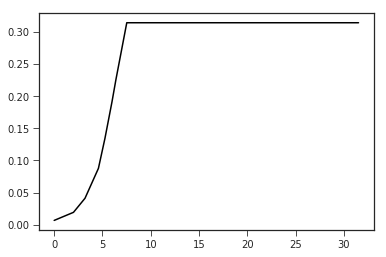

In [50]:
import seaborn as sns
%matplotlib inline

plt.plot(result['time'], result['biomass'])

In [51]:
ex_met_rxn_dict = {m: {'rxn':dyme.get_exchange_rxn(m), 'mw':me.metabolites.get_by_id(m).formula_weight} for m in c0_dict.keys()}
ex_met_rxn_dict

{'ac_e': {'mw': 59.04402, 'rxn': <Reaction EX_ac_e at 0x7f2f4c71c390>},
 'gal_e': {'mw': 180.15588, 'rxn': <Reaction EX_gal_e at 0x7f2f4c66da50>},
 'glc__D_e': {'mw': 180.15588,
  'rxn': <Reaction EX_glc__D_e at 0x7f2f4c688290>},
 'glyc_e': {'mw': 92.09382, 'rxn': <Reaction EX_glyc_e at 0x7f2f4c615cd0>},
 'lac__L_e': {'mw': 89.07, 'rxn': <Reaction EX_lac__L_e at 0x7f2f4c5d5bd0>},
 'malt_e': {'mw': 342.29648, 'rxn': <Reaction EX_malt_e at 0x7f2f4c5ea090>}}

In [52]:
import pandas as pd

df_conc = pd.DataFrame(result['concentration'])
### Convert concentrations to g/L
for mid, vals in ex_met_rxn_dict.iteritems():
    df_conc[mid] = df_conc[mid] * vals['mw'] * 0.001

df_time = pd.DataFrame({'time':t, 'biomass':b} for t,b in zip(result['time'], result['biomass']))
df_flux = pd.DataFrame(result['ex_flux'])
df_mu   = pd.DataFrame({'mu':result['growth_rate']})
df_result = pd.concat([df_time, df_conc, df_flux, df_mu], axis=1)

In [66]:
dsplot = pd.melt(df_result, id_vars='time', value_vars=['biomass','ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'])

dsplot = dsplot[ dsplot.time <= 10]

dsplot.time = pd.to_numeric(dsplot.time)
dsplot['category'] = 'Metabolite'
dsplot.loc[ dsplot.variable=='biomass', 'category'] = 'Biomass'

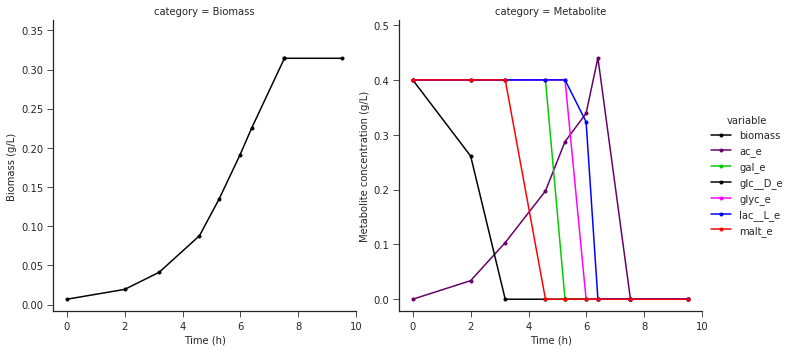

In [67]:
colors = [
'#000000', # biomass
'#660066', # acetate
'#00CC00', #'#00FF00', # galactose
'#000000', # glucose
'#FF00FF', # glycerol
'#0000FF', # lactate
'#FF0000', # maltose
]

colpal = sns.color_palette(colors)
sns.set_palette(colpal)

g = sns.FacetGrid(data=dsplot, hue='variable', col='category', sharey=False, size=5)

g.map(plt.plot, 'time', 'value', linestyle='-', marker='.')
for i,ax in enumerate(g.axes.flat):
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[0],ylim[1]*1.1))
    if i==0:
        ax.set_ylabel('Biomass (g/L)')
    else:
        ax.set_ylabel('Metabolite concentration (g/L)')
g.set_xlabels('Time (h)')
g.add_legend()

In [68]:
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt_longH_R03_DHkapp_subset.pdf')
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt_longH_R03_DHkapp_subset.svg')
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt_longH_R03_DHkapp_subset.eps')

# Test/Debug
Take the last proteome and try to grow on left over substrates

In [69]:
conc_dict_fin = result['complex'][-1]

dyme.delay_model.update_cplx_concs(conc_dict_fin)

In [70]:
for rxn in dsolver.me.reactions.query('EX_'):
    if rxn.lower_bound < 0:
        x = result['rxn_flux'][-1][rxn.id]
        print '%-15.15s%-25.20s%-35s' % (x, rxn.lower_bound, rxn.id)

0.0            -1000.0                  EX_ca2_e                           
0.0            -1000.0                  EX_cl_e                            
0.0            -1000.0                  EX_co2_e                           
0.0            -1000.0                  EX_cobalt2_e                       
0.0            -1000.0                  EX_cu2_e                           
0.0            -1000.0                  EX_fe2_e                           
0.0            -1000.0                  EX_fe3_e                           
0.0            -1000.0                  EX_h_e                             
0.0            -1000.0                  EX_h2o_e                           
0.0            -1000.0                  EX_k_e                             
0.0            -1000.0                  EX_mg2_e                           
0.0            -1000.0                  EX_mn2_e                           
0.0            -1000.0                  EX_mobd_e                          
0.0         

muopt, hs, xopt, cache = dsolver.bisectmu(basis=dsolver.feas_basis)

In [71]:
if PROTOTYPE:
    complexes_plot = ['IPPMIa_E_c', 'ACKr_reverse_E_c', 'CPLX0-7760_mod_4fe4s','CPLX0-7761_mod_4fe4s']
else:
    complexes_plot = ['3-ISOPROPYLMALISOM-CPLX_mod_4fe4s', 'ACETATEKINA-MONOMER_mod_mg2', 'CPLX0-7659']

In [72]:
len(fluxes_plot)

15535

In [73]:
fluxes_plot2 = []

for rid in fluxes_plot:
    rxn = dsolver.me.reactions.get_by_id(rid)
    x   = result['rxn_flux'][0][rid]
    try:
        if abs(x) > 1:
            fluxes_plot2.append(rxn.id)
    except:
        pass
        
print len(fluxes_plot2)

0


In [74]:
df_mu = pd.DataFrame([{'time':t, 'variable':'growth_rate', 'value':c, 'category':'growth'} for t,c in zip(result['time'], result['growth_rate'])] )

df_complex = pd.DataFrame([{'time':t, 'complex':c, 'abundance':cdict[c]} 
                           for t,cdict in zip(result['time'], result['complex']) for c in complexes_plot] )

df_mflux = pd.DataFrame([{'time':t, 'rxn':c, 'flux':cdict[c]} 
                           for t,cdict in zip(result['time'], result['rxn_flux']) for c in fluxes_plot2] )

df_complex.loc[:,'category'] = 'complex'
try:
    df_mflux.loc[:,'category'] = 'flux'
except:
    pass

dsplot_all = pd.concat([dsplot,
                        df_mu,
                          df_complex.rename(columns={'complex':'variable', 'abundance':'value'}),
                          df_mflux.rename(columns={'rxn':'variable', 'flux':'value'})])

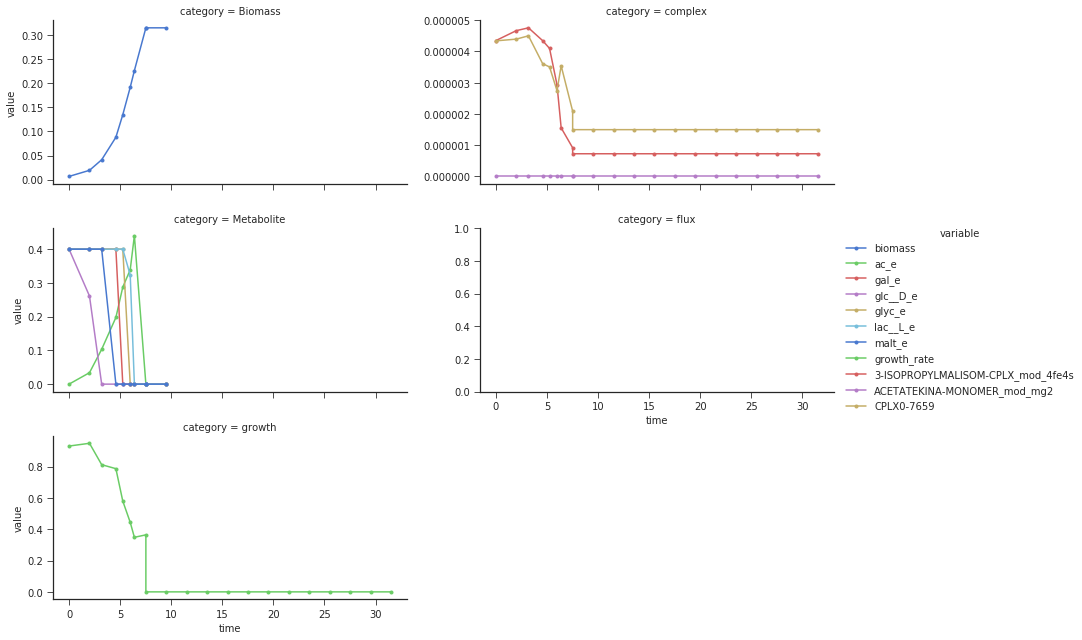

In [75]:
sns.set_style('ticks')
palette = sns.color_palette('muted', len(dsplot_all.variable.unique()))
g = sns.FacetGrid(data=dsplot_all, hue='variable', sharey=False, size=3, col='category', palette=palette,
                  aspect=2, col_wrap=2, col_order=['Biomass','complex','Metabolite','flux','growth'])
g.map(plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

### In general, it seems virtual cell lacks capacity to replenish the continuously diluting proteome.
### Actually, not entirely true--see very rapid rise in ACK protein. But is that because it's cheaper (recall Hwa's overflow mechanism--ATP per protein cost)
### Need to start it off with much more ribosome?

## Proteome mol (mass) fractions

In [76]:
#df_super = pd.read_csv('/home/laurence/ME/data/cobrame/proteome_letter/subsystem-supersystem-mapping.csv')
df_system = pd.read_csv('/home/laurence/ME/data/cobrame/proteome_letter/sub_supersystem.csv')
df_system.shape

# df_trsl = pd.DataFrame([{'rxn':k, 'v':v, 'time':result['time'][i]} for i,r in enumerate(result['rxn_flux']) for k,v in r.iteritems() if 'translation_' in k])

import re
patt = re.compile(r"protein_(b\d\d\d\d)_?\S?")

cplx_prot = pd.DataFrame([{'cplx':d.id, 'locus':re.findall(patt,k)[0]} for d in me.complex_data for k,v in d.stoichiometry.iteritems() if 'protein_b' in k])

df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

df_cplx_mass = pd.merge(df_cplx_mass, cplx_prot, on='cplx', how='left')

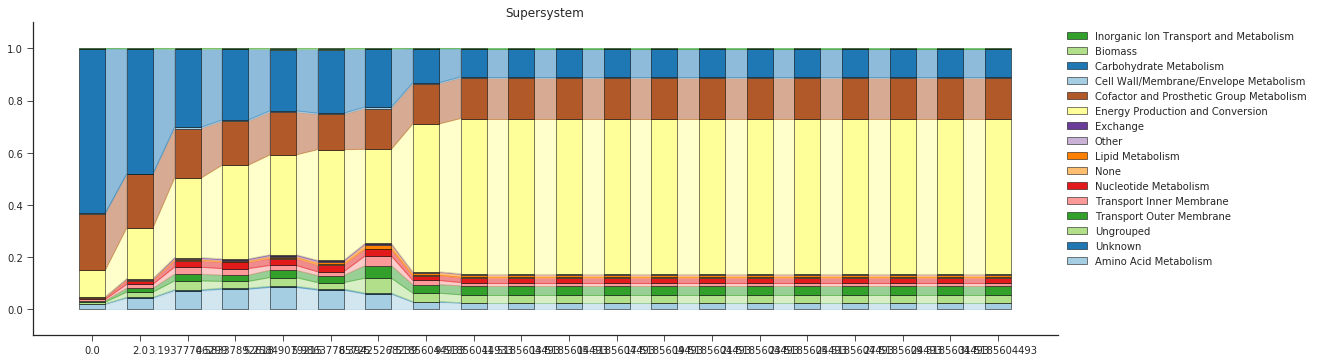

In [77]:
#syslevel = 'Subsystem'
syslevel = 'Supersystem'

df_level = df_system[['gene',syslevel]].drop_duplicates()

df_cplx_sub = pd.merge(df_cplx_mass, df_level, left_on='locus', right_on='gene', how='left')
df_cplx_sub.loc[ df_cplx_sub[syslevel].isnull(), syslevel] = 'Ungrouped'

df_mf_sector = df_cplx_sub.groupby(['time',syslevel]).mf.sum().reset_index()
# Renormalize to 1
dsplot_sector = df_mf_sector.copy()
for t in dsplot_sector.time.unique():
    b = dsplot_sector.time==t
    mtot = sum(dsplot_sector.loc[b,'mf'])
    dsplot_sector.loc[b, 'mf'] = dsplot_sector.loc[b, 'mf']/mtot

from stressme.plot import stacked_bar

dsplot_sector.loc[:,'group'] = syslevel
g = stacked_bar('time', 'mf', dsplot_sector, syslevel, 'group', size=5, aspect=3, palette_name='Paired')

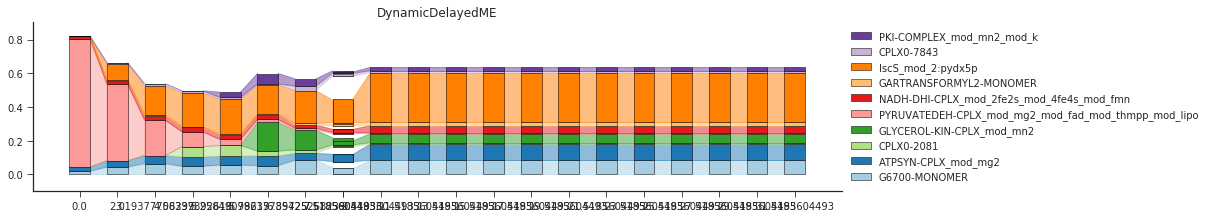

In [78]:
df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

#df_var = df_cplx_mass.groupby('cplx').mf.var().reset_index()
df_var = df_cplx_mass.groupby('cplx').mf.mean().reset_index()
N_PLOT = 10
vary_cplxs = df_var.sort_values('mf', ascending=False)['cplx'][0:N_PLOT].values
vary_cplxs

df_cplx_mass[ df_cplx_mass.time==0].mf.sum()

from stressme.plot import stacked_bar

dsplot_cplx = df_cplx_mass[ df_cplx_mass.cplx.isin(vary_cplxs)]
dsplot_cplx.loc[:,'group'] = 'DynamicDelayedME'
stacked_bar('time', 'mf', dsplot_cplx, 'cplx', 'group', aspect=4, palette_name='Paired')